In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

# https://docs.google.com/document/d/1LL4WSKmWF8637Fn9xz0GPnytO0-4xYwyy1hQJUpmsmY/edit?usp=sharing 

In [3]:
source = 'Version1.csv'
source = 'data.csv'

In [4]:
data = pd.read_csv(source)
pretty_cols = list(data.columns)
pretty_cols

['TAIP (ms)',
 'Respiratory Rate (breaths/min)',
 'I:E Ratio',
 'Target Peak Pressure (cm H2O)',
 'Observed Peak Pressure (cm H2O)',
 'PEEP (cm H2O)',
 'Lung Compliance (mL / cm H2O)',
 'Airway Resistance (cm H2O / (L/s) )',
 'Tidal Volume (mL)',
 'Unnamed: 9',
 'I am working on the scopes tonight']

In [5]:
pretty_cols[0] = "Rise Time (ms)"
print(pretty_cols)
easy_cols = ['rise', 'rate', 'ie', 'p', 'p_observed', 'peep', 'compliance', 'resistance', 'tv', 'flow', 'rubbish']
units = dict(zip(easy_cols,['ms', '/min', '', 'cmH2O', 'cmH2O', 'cmH2O', 'mL/cmH2O', 'cmH2O/L/s', 'mL', 'L/min']))
pretty = dict(zip(easy_cols, pretty_cols))
dependant = ['p_observed', 'tv', 'flow']
independant = [c for c in easy_cols if c not in dependant]
data.columns = easy_cols #[pretty_cols]
data['alveolarMV'] = (data.rate * (data.tv - 150)).clip(0, 100000)
pretty['alveolarMV'] = "Alveolar Minute Volume"
print(f"dependant {dependant}, independant {independant}")
data.sort_values(independant, inplace=True)
display(data.head())

['Rise Time (ms)', 'Respiratory Rate (breaths/min)', 'I:E Ratio', 'Target Peak Pressure (cm H2O)', 'Observed Peak Pressure (cm H2O)', 'PEEP (cm H2O)', 'Lung Compliance (mL / cm H2O)', 'Airway Resistance (cm H2O / (L/s) )', 'Tidal Volume (mL)', 'Unnamed: 9', 'I am working on the scopes tonight']
dependant ['p_observed', 'tv', 'flow'], independant ['rise', 'rate', 'ie', 'p', 'peep', 'compliance', 'resistance', 'rubbish']


,rise,rate,ie,p,p_observed,peep,compliance,resistance,tv,flow,rubbish,alveolarMV
14,0,12,2,20,14.9154,5,10,3,149.1469,NaN,NaN,0.0000
29,0,12,2,20,14.8932,5,10,5,148.9084,NaN,NaN,0.0000
44,0,12,2,20,14.6187,5,10,10,146.0571,NaN,NaN,0.0000
59,0,12,2,20,14.5364,5,10,20,144.6980,NaN,NaN,0.0000
2,0,12,2,20,14.5412,5,25,1,363.4004,NaN,NaN,2560.8048


In [6]:
# These are our variables:
for i in independant:
    if len(data[i].unique()) > 1:
        values = data[i].unique()
        values.sort()
        print(f"{i} {values}" )

rise [   0  250  500 1000 2000]
rate [12 20 30]
compliance [ 10  25  50 100 200]
resistance [ 1  3  5 10 20]


In [7]:
def describe(data):
    print(f" {len(data.columns)} x {len(data)}")

In [8]:
# a function to extract the data for set of conditions
# makes use of the panda.query method
def get(data, filters):
     # rise = 0, rate = 12, ie = 2, p = 20, peep = 5, compliance = 100, resistance = 3
    query = ' & '.join([f"{c} == {v}" for c, v in filters.items()])
    # print (query)
    return data.query(query)

In [9]:
plt.rcParams['figure.figsize'] = [12, 12]
def sub_plot(data, filter_in, ax, series='rise', subseries='compliance', dependant='tv', title=''):
    filter = filter_in.copy()
    del filter[series]
    del filter[subseries]
    all_rows = get(data, filter)
    clean = all_rows.drop_duplicates(subset=[series, subseries], ignore_index=True, keep='first')
    if len(all_rows) > len(clean):
        print(f"WARNING went from {len(all_rows)} to {len(clean)} rows are cleaning {filter} (This shouldn't really be happening!)")
    df1 = clean.pivot(index=series, columns=subseries, values=dependant)
    df1.plot(ax=ax, title=title)

In [15]:
def plot_matrix(data, vars, units=units, dependant='tv', pretty=pretty):
    base_filter = {"rise": 0, "rate": 12, "ie": 2, "p": 20, "peep": 5, "compliance": 100, "resistance": 3}
    xvar = vars[2]
    yvar = vars[1]
    svar = vars[0]
    ssvar = vars[3]
    print(f"{vars} Rows = {xvar}, Cols = {yvar}, X={svar}, series={ssvar} ")
    xs = data[xvar].unique()
    ys = data[yvar].unique()
    xs.sort()
    ys.sort()
    fig, axes = plt.subplots(nrows=len(xs), ncols=len(ys), constrained_layout=True)
    fig.suptitle(f" {pretty[dependant]} by {xvar.title()}, {yvar.title()}, {svar.title()} and {ssvar.title()}", fontsize=16)
    for xi, x in enumerate(xs):
        for yi, y in enumerate(ys):
            # print(f"{xi}, {yi} {xvar}={x}\n{yvar}={y}, {svar}, {ssvar}")
            filter = base_filter.copy()
            filter[xvar] = x
            filter[yvar] = y
            # print(filter)
            ax = axes[xi, yi]
            ax.set_ylim(0, 1000 if dependant=='tv' else 15000)
            if len(xs) - xi > 1:
                # hiding x marks
                ax.xaxis.label.set_visible(False)
                ax.get_xaxis().set_visible(False)
            if yi > 0:
                # hiding yx marks
                ax.yaxis.label.set_visible(False)
                ax.get_yaxis().set_visible(False)
            sub_plot(data, filter, ax, series=svar, subseries=ssvar, dependant=dependant)
            if xi == 0 and len(ys) - yi == 1:
                ax.legend(loc='upper right', title=f"{ssvar.title()}\n({units[ssvar]})")
            else:
                # hiding legend!
                ax.legend().set_visible(False)
            if xi == 0:
                ax.set_title(f"{yvar.title()} {y}{units[yvar]}")
            if yi == 0:
                ax.set_ylabel(f"{xvar.title()}={x}{units[xvar]}")
            ax.set_xlabel(pretty[svar])
    plt.show()

['rise', 'rate', 'compliance', 'resistance'] Rows = compliance, Cols = rate, X=rise, series=resistance 
WARNING went from 25 to 24 rows are cleaning {'rate': 12, 'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10} (This shouldn't really be happening!)


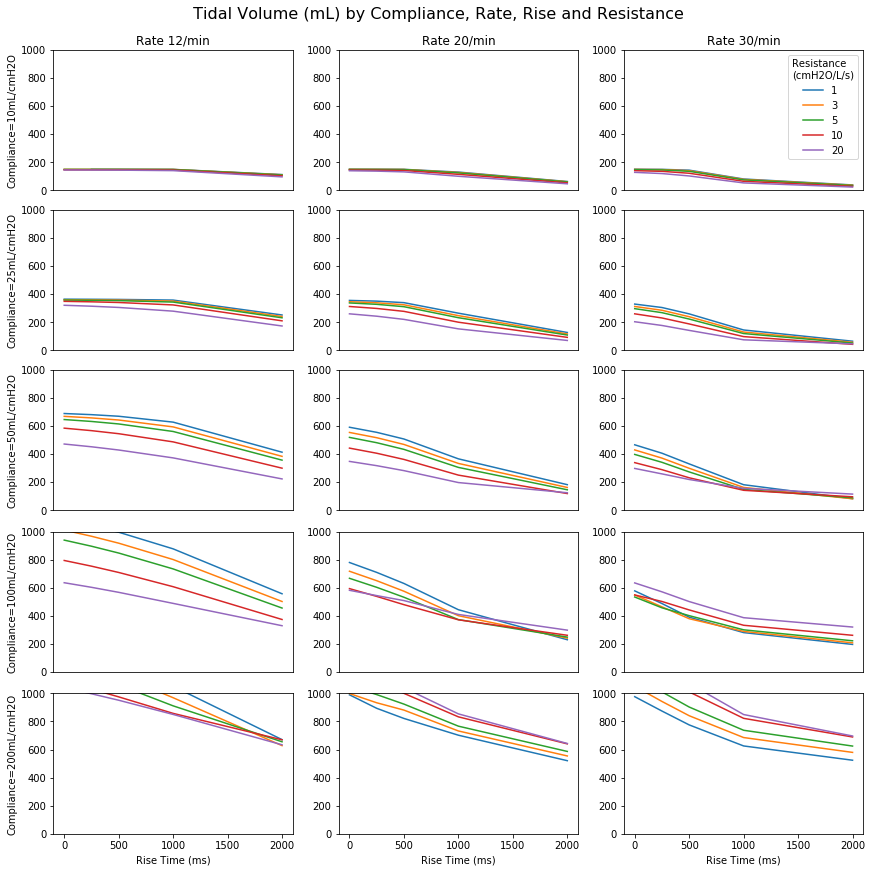

['rise', 'rate', 'compliance', 'resistance'] Rows = compliance, Cols = rate, X=rise, series=resistance 
WARNING went from 25 to 24 rows are cleaning {'rate': 12, 'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10} (This shouldn't really be happening!)


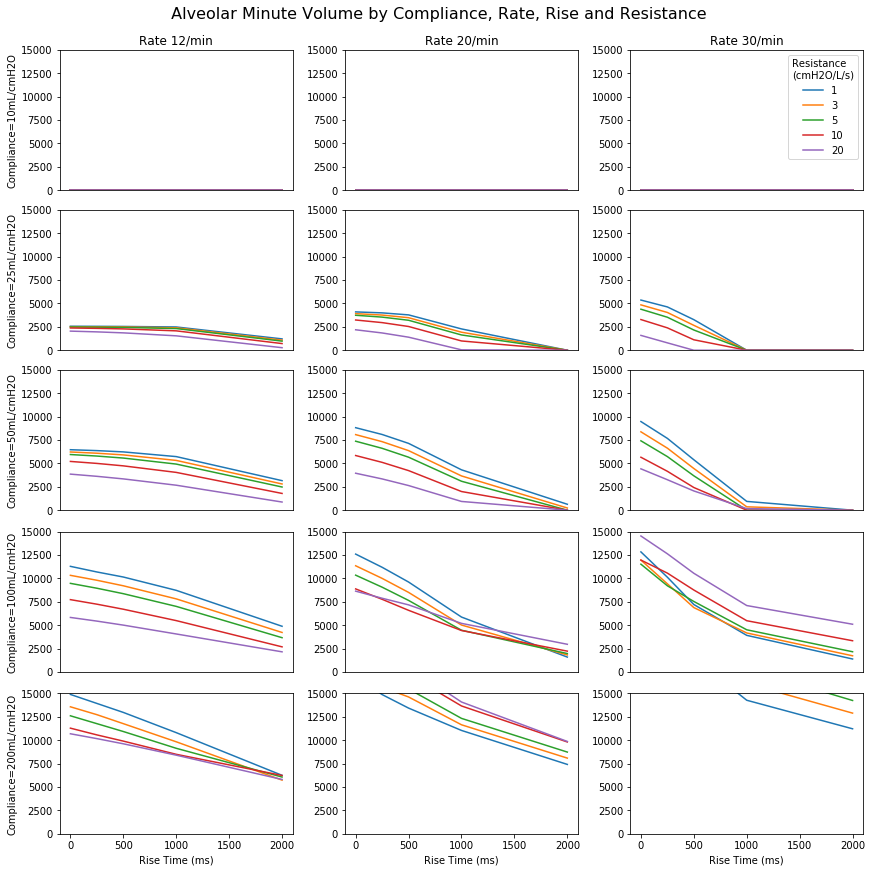

['rise', 'rate', 'resistance', 'compliance'] Rows = resistance, Cols = rate, X=rise, series=compliance 
WARNING went from 25 to 24 rows are cleaning {'rate': 12, 'ie': 2, 'p': 20, 'peep': 5, 'resistance': 1} (This shouldn't really be happening!)


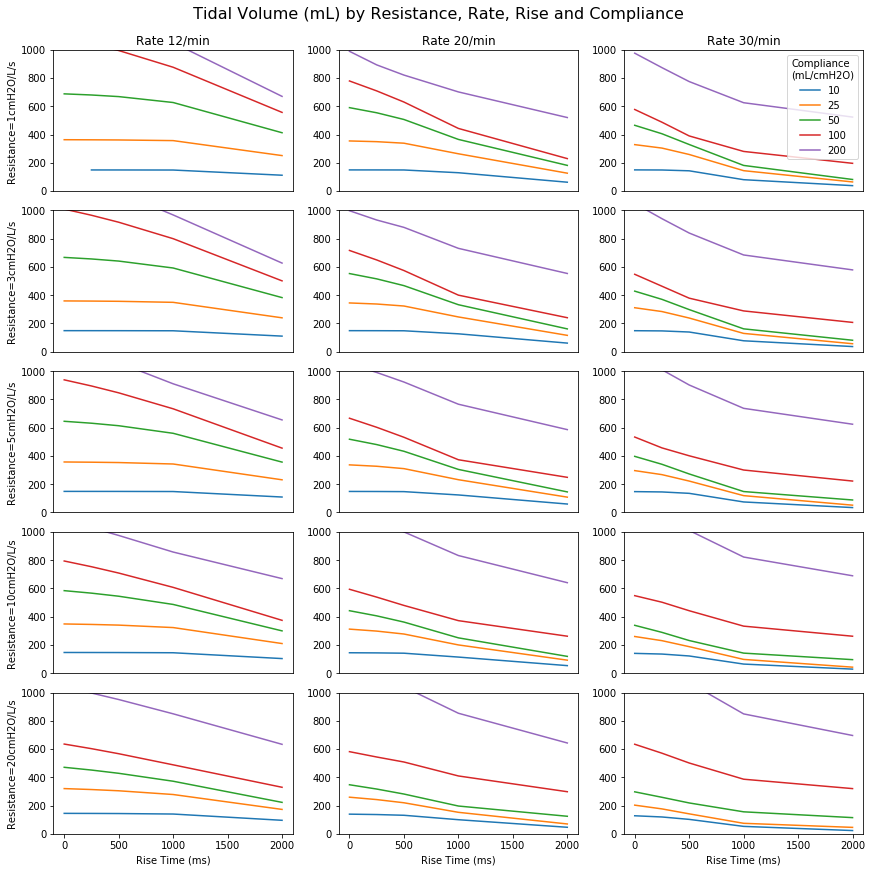

['rise', 'rate', 'resistance', 'compliance'] Rows = resistance, Cols = rate, X=rise, series=compliance 
WARNING went from 25 to 24 rows are cleaning {'rate': 12, 'ie': 2, 'p': 20, 'peep': 5, 'resistance': 1} (This shouldn't really be happening!)


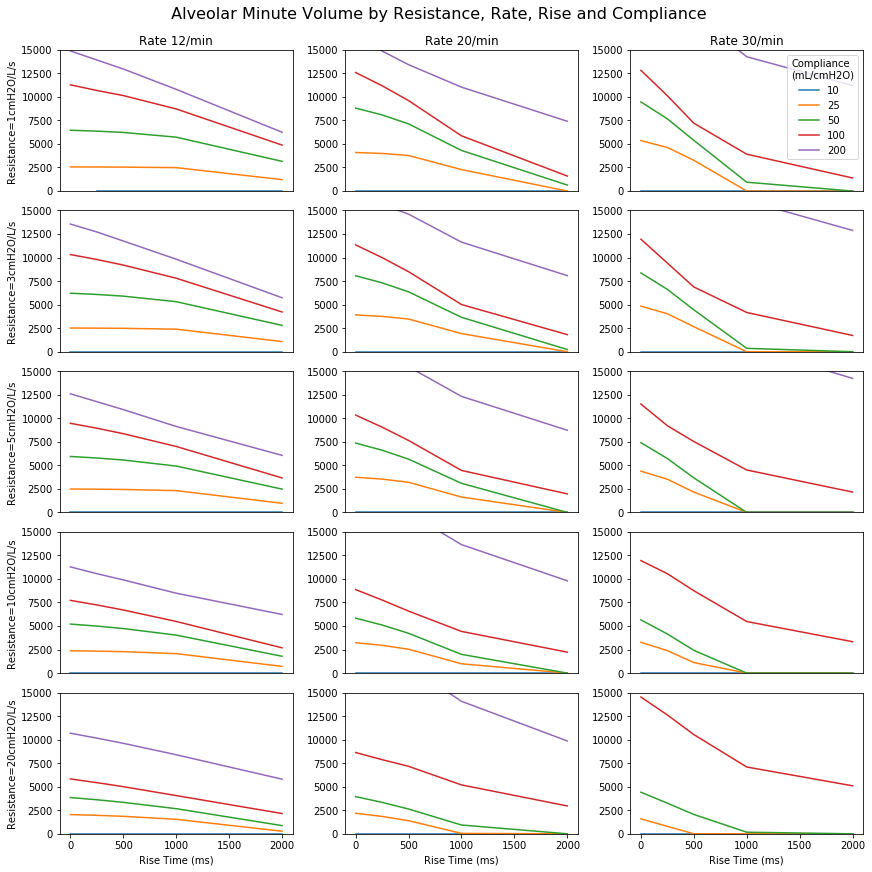

['rise', 'resistance', 'compliance', 'rate'] Rows = compliance, Cols = resistance, X=rise, series=rate 
WARNING went from 15 to 14 rows are cleaning {'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10, 'resistance': 1} (This shouldn't really be happening!)


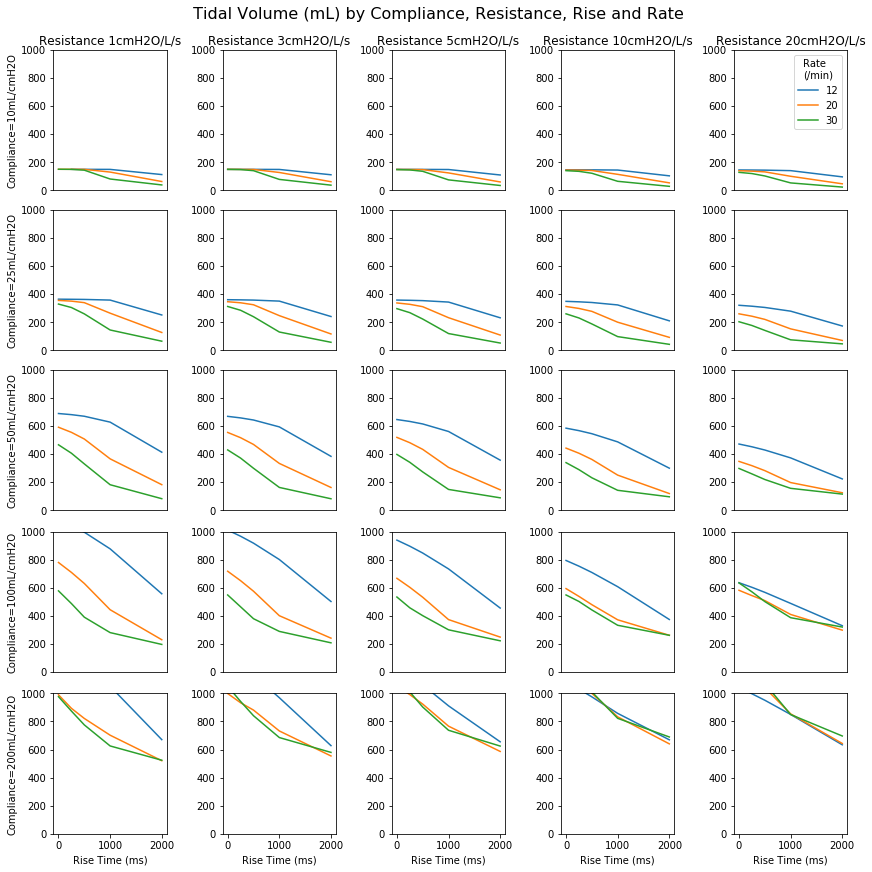

['rise', 'resistance', 'compliance', 'rate'] Rows = compliance, Cols = resistance, X=rise, series=rate 
WARNING went from 15 to 14 rows are cleaning {'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10, 'resistance': 1} (This shouldn't really be happening!)


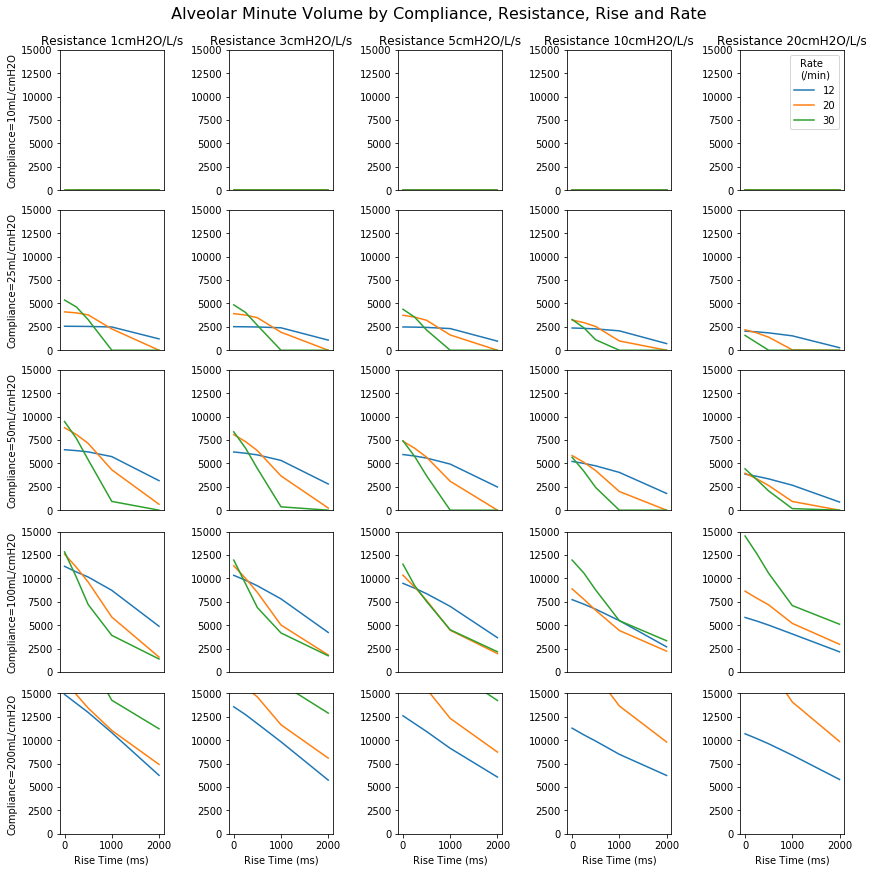

In [16]:
trace = 1
for priority in [
        ['rise', 'rate', 'compliance', 'resistance'],
        ['rise', 'rate', 'resistance', 'compliance'],
        ['rise', 'resistance', 'compliance','rate' ]]:
    for dependant in ['tv','alveolarMV']:
        display(HTML(f"<h1>Figure {trace}</h1>"))
        plot_matrix(data, priority, dependant=dependant)
        trace += 1


In [20]:
def describe(row):
    return {
        "Scenario": f"{row.index.name}={row.index[0]}", 
        "median tidal volume": round(row.median(axis=1).values[0],1),
        "median tidal volume at rise=0": row[0].values[0].round(1),
        "median tidal volume at rise=2000": row[2000].values[0].round(1),
        "difference": round(row[0].values[0]-row[2000].values[0], 1),
        "ratio": round(row[0].values[0]/row[2000].values[0],1)
    }
    #return f"{row.index.name} of {row.index[0]} median tidal volume ranged from {row.values.min():.0f} to {row.values.max():.0f}, a factor of {row.values.max()/row.values.min():.1f}"


for dependant in ['tv','alveolarMV']:
    ex = []
    for f in ['rate', 'compliance', 'resistance']:
        display(HTML(f"<h3>Median {pretty[dependant]} by {f.title()}</h3>"))
        #display(data.groupby([f])[['tv']].median().round(1))
        display(pd.crosstab(data[f], data.rise, values=data[dependant], aggfunc=np.median, margins=True).round(1))
        med = pd.crosstab(data[f], data.rise, values=data[dependant], aggfunc=np.median)
        ex.append(describe(med.head(1)))
        ex.append(describe(med.tail(1)))

    display(pd.DataFrame(ex))
    print('--')

rise,0,250,500,1000,2000,All
rate,,,,,,
12,640.3,602.8,567.1,488.3,314.2,486.2
20,518.2,480.3,432.9,304.5,145.2,338.7
30,396.9,340.8,272.4,155.6,88.0,272.4
All,494.5,451.3,379.2,322.5,202.0,349.7


rise,0,250,500,1000,2000,All
compliance,,,,,,
10,147.9,147.4,143.5,123.7,60.3,139.9
25,328.6,313.4,304.6,231.6,108.1,267.5
50,470.9,451.3,428.4,304.5,145.2,370.7
100,635.4,602.8,532.1,400.7,261.3,533.7
200,1110.0,1030.0,974.7,832.5,633.5,942.0
All,494.5,451.3,379.2,322.5,202.0,349.7


rise,0,250,500,1000,2000,All
resistance,,,,,,
1,583.9,487.3,390.1,357.1,188.9,365.5
3,548.3,463.8,379.2,332.9,207.7,359.7
5,518.2,456.9,401.0,304.5,222.0,355.5
10,441.8,405.4,361.3,322.5,209.3,338.4
20,347.3,316.9,304.6,278.2,172.7,304.6
All,494.5,451.3,379.2,322.5,202.0,349.7


,Scenario,median tidal volume,median tidal volume at rise=0,median tidal volume at rise=2000,difference,ratio
0,rate=12,567.1,640.3,314.2,326.1,2.0
1,rate=30,272.4,396.9,88.0,308.9,4.5
2,compliance=10,143.5,147.9,60.3,87.6,2.5
3,compliance=200,974.7,1110.0,633.5,476.5,1.8
4,resistance=1,390.1,583.9,188.9,395.0,3.1
5,resistance=20,304.6,347.3,172.7,174.6,2.0


--


rise,0,250,500,1000,2000,All
rate,,,,,,
12,5883.5,5433.6,5004.6,4060.1,1970.5,4034.6
20,7364.6,6606.3,5658.1,3089.9,0.0,3774.7
30,7407.3,5723.3,3670.7,168.7,0.0,3670.7
All,6078.8,5723.3,4733.0,2666.9,791.2,3850.4


/home/erich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


rise,0,250,500,1000,2000,All
compliance,,,,,,
10,0.0,0.0,0.0,0.0,0.0,0.0
25,3228.8,2552.4,2483.7,1538.2,0.0,2276.4
50,6214.9,5779.5,4733.0,2666.9,0.0,4226.4
100,11280.0,9415.0,7642.4,5191.8,2226.1,7530.4
200,18000.0,16818.8,15464.1,12323.1,8725.2,14234.1
All,6078.8,5723.3,4733.0,2666.9,791.2,3850.4


/home/erich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


rise,0,250,500,1000,2000,All
resistance,,,,,,
1,9136.3,7667.4,6223.7,3911.7,922.2,4881.7
3,8068.4,6622.3,5902.5,3657.5,1081.1,4221.3
5,7364.6,5779.5,5566.1,3089.9,971.6,3733.4
10,5653.3,4994.2,4226.4,2069.7,711.8,3276.2
20,3945.7,3338.3,2631.0,1538.2,271.9,2631.0
All,6078.8,5723.3,4733.0,2666.9,791.2,3850.4


,Scenario,median tidal volume,median tidal volume at rise=0,median tidal volume at rise=2000,difference,ratio
0,rate=12,5004.6,5883.5,1970.5,3913.0,3.0
1,rate=30,3670.7,7407.3,0.0,7407.3,inf
2,compliance=10,0.0,0.0,0.0,0.0,NaN
3,compliance=200,15464.1,18000.0,8725.2,9274.8,2.1
4,resistance=1,6223.7,9136.3,922.2,8214.1,9.9
5,resistance=20,2631.0,3945.7,271.9,3673.8,14.5


--
